# Informatyka systemów złożonych – laboratorium 3
## Mateusz Kocot

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

import time

from ba import BA

# Zadanie 1. Model rosnącego grafu scale-free: Barabasi-Albert (BA)

Elapsed 0.01 s


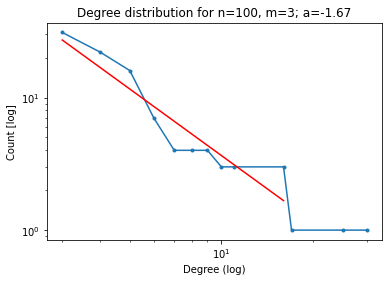

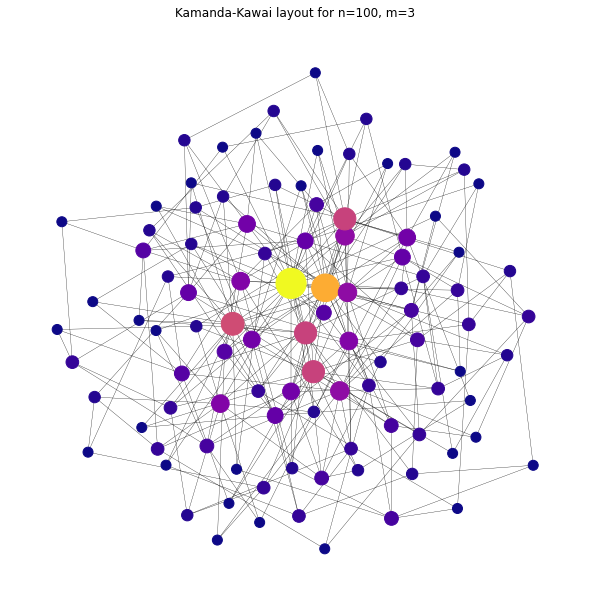

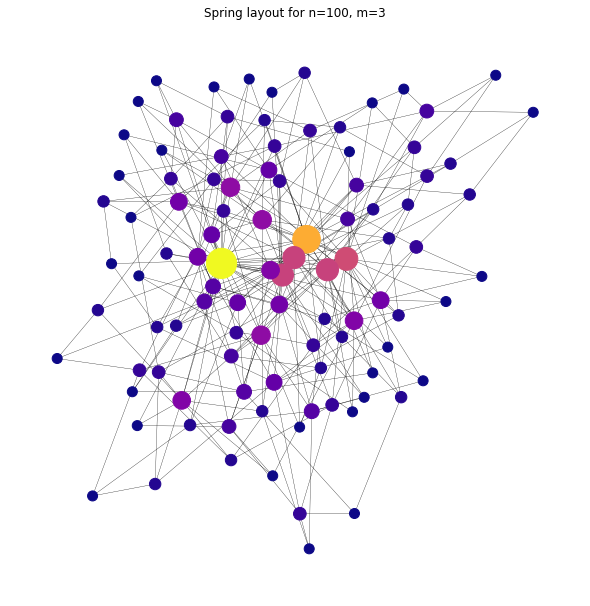

Elapsed 0.04 s


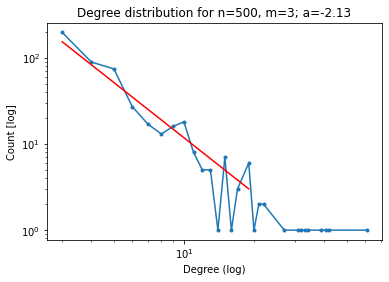

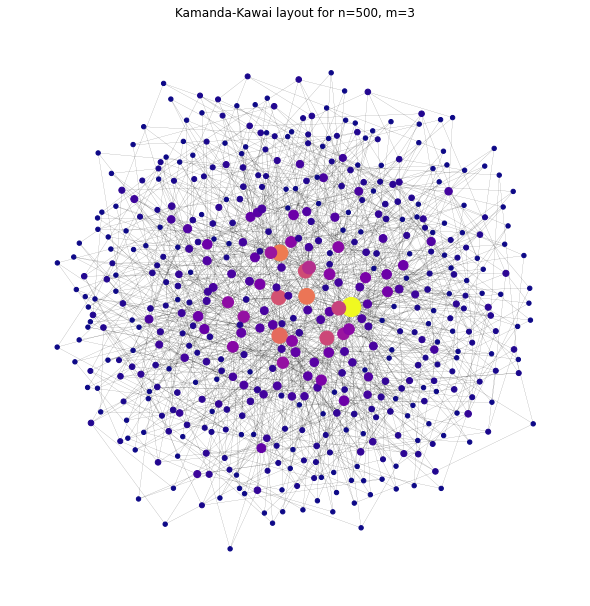

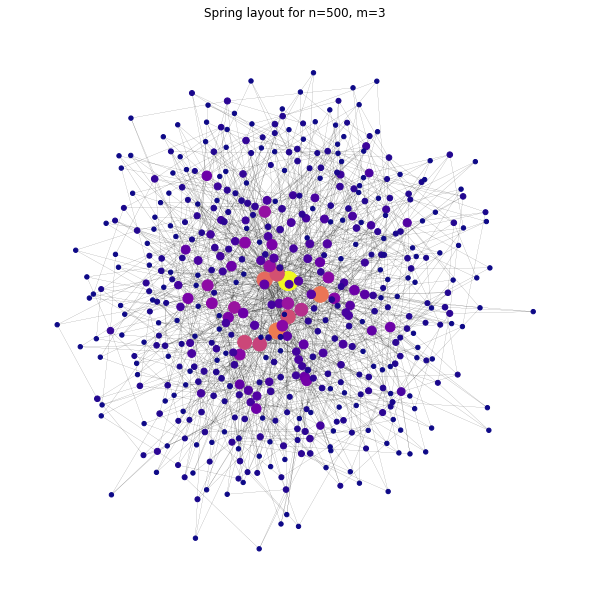

Elapsed 1.13 s


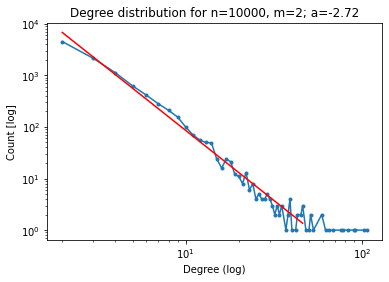

Elapsed 1.16 s


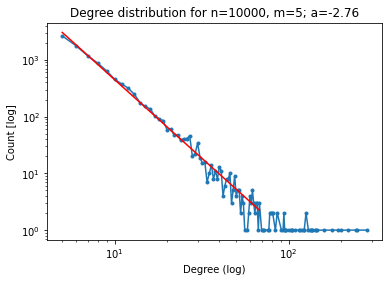

Elapsed 15.88 s


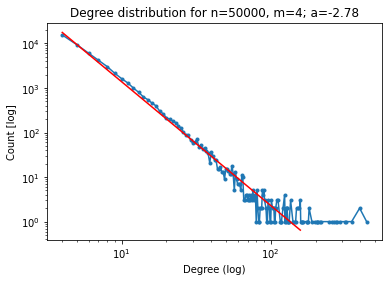

Elapsed 15.78 s


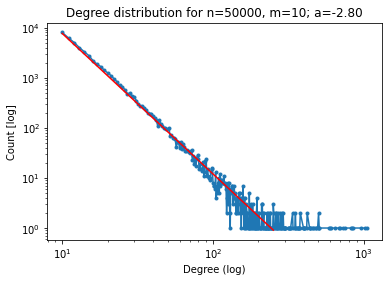

In [2]:
for n, m in [(100, 3), (500, 3), (10_000, 2), (10_000, 5), (50_000, 4), (50_000, 10)]:
    ba = BA(n, m, compute_adj=(n <= 1000))
    start = time.time()
    ba.build()
    print(f'Elapsed {time.time() - start:0.2f} s')
    degrees = ba.get_degrees()
    
    x, y = np.unique(degrees, return_counts=True)
    plt.loglog(x, y, marker='.')
    
    x_fit, y_fit = np.log10(x)[y > 2], np.log10(y)[y > 2]
    a, b = np.polyfit(x_fit, y_fit, 1)
    plt.plot([10 ** x_fit[0], 10 ** x_fit[-1]], [10 ** (x_fit[0] * a + b), 10 ** (x_fit[-1] * a + b)] , c='red')
    
    plt.title(f'Degree distribution for n={n}, m={m}; a={a:0.2f}')
    plt.xlabel('Degree (log)')
    plt.ylabel('Count [log]')
    plt.show()
    
    if n <= 1000:
        G = nx.from_dict_of_lists(ba.adj)
        if n <= 100:
            sizes = 10 + 30 * ba.get_degrees()
            width = 0.3
        else:
            sizes = 1 + 6 * ba.get_degrees()
            width = 0.1
        colors = ba.get_degrees()
        
        plt.figure(figsize=(8, 8))
        nx.draw(G, pos=nx.kamada_kawai_layout(G), node_size=sizes, node_color=colors, width=width, cmap='plasma')
        plt.title(f'Kamanda-Kawai layout for n={n}, m={m}')
        plt.show()

        plt.figure(figsize=(8, 8))
        nx.draw(G, pos=nx.spring_layout(G), node_size=sizes, node_color=colors, width=width, cmap='plasma')
        plt.title(f'Spring layout for n={n}, m={m}')
        plt.show()

# Zadanie 2. Odporność grafu scale-free na błędy i ataki